In [3]:
import pickle
import sys
import pandas as pd
from os.path import join
import os
import numpy as np

In [4]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
import matplotlib.pyplot as plt

In [7]:
data_folder = "../data/preprocessed/"
X = pd.read_pickle(join(data_folder, "X.pk.zip"))
y = pd.read_pickle(join(data_folder, "Y.pk.zip"))

X_mat = X.values
y_vec = y.values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=0.12, random_state=123)


In [8]:
sys.stdout.write(f"The number of features: {X_mat.shape[1]}\n")
sys.stdout.write(f"TRAIN \
0: {np.sum(y_train == 0)}, 1: {np.sum(y_train == 1)}, 2: {np.sum(y_train == 2)}\n")

sys.stdout.write(f"TEST  \
0: {np.sum(y_test == 0)}, 1: {np.sum(y_test == 1)}, 2: {np.sum(y_test == 2)}\n")

The number of features: 195
TRAIN 0: 1802, 1: 2487, 2: 57936
TEST  0: 239, 1: 348, 2: 7899


30

# Model

## SKlearn - like

In [9]:
classifiers = {
    "Tree w": DecisionTreeClassifier(class_weight='balanced'),
    "Tree cw": DecisionTreeClassifier(criterion = 'log_loss',
                                     class_weight='balanced'),
    # "LGBMC": LGBMClassifier(class_weight={0: 5, 1: 5, 2: 1}),
    "LGBMC": LGBMClassifier(),
    "LGBMC bo": LGBMClassifier(
        class_weight='balanced',
    objective = 'multiclass')
}

In [10]:
# preprocessor.

In [11]:
preprocessor = StandardScaler()
for cla in classifiers:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        , ('classifier', classifiers[cla])
    ])
    model = pipeline.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = f1_score(predictions, y_test, average=None)
    score2 = cohen_kappa_score(y_test, predictions)
    print(f'Model:{cla}; score:{score2}; all_score:{score}')

Model:Tree w; score:0.01708534645955373; all_score:[0.04624277 0.05722071 0.92753992]
Model:Tree cw; score:0.02407508162385008; all_score:[0.05681818 0.0541272  0.92760267]
Model:LGBMC; score:0.007278791126420936; all_score:[0.01626016 0.         0.96409818]
Model:LGBMC bo; score:0.03782731570286835; all_score:[0.08225617 0.07469414 0.86010434]


## lgb-like

In [19]:
def kappa_metric(dy_true, dy_pred):
    """An eval metric that always returns the same value"""
    metric_name = 'constant_metric'
    preds = dy_pred.reshape(3, -1).T
    preds = preds.argmax(axis = 1)
    value = cohen_kappa_score(dy_true, dy_pred)
    is_higher_better = True
    return metric_name, value, is_higher_better

evals_result = {}


def calc_custom_kappa(actuals, preds, n=3):
    # from here
    # https://www.kaggle.com/code/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps/notebook
    # but later it's better to move to something like that
    # https://www.kaggle.com/code/tsmith26/lightgbm-custom-objective-for-weighted-kappa
    conf_m = confusion_matrix(actuals, preds)
    w = np.zeros((n, n))
    for i_ in range(len(w)):
        for j_ in range(len(w)):
            w[i_][j_] = float(((i_ - j_) ** 2) / (n - 1) ** 2)

    act_hist = np.zeros([n])
    for item in actuals:
        act_hist[item] += 1

    pred_hist = np.zeros([n])
    for item in preds:
        pred_hist[item] += 1
    e_mat = np.outer(act_hist, pred_hist)

    e_mat = e_mat / e_mat.sum()
    conf_m = conf_m / conf_m.sum()

    num = 0
    den = 0
    for i_ in range(len(w)):
        for j_ in range(len(w)):
            num += w[i_][j_] * conf_m[i_][j_]
            den += w[i_][j_] * e_mat[i_][j_]

    weighted_kappa = (1 - (num / den))
    return weighted_kappa




def evalerror(preds, dtrain):

    labels = dtrain.get_label()
    preds = preds.reshape(3, -1).T
    preds = preds.argmax(axis = 1)
    f_score = f1_score(labels , preds,  average = 'weighted')
    return 'f1_score', f_score, True

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
train_data = lgb.Dataset(X_train_sc, label=y_train)
validation_data = lgb.Dataset(X_test_sc, label=y_test)

In [17]:
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'metric': 'multi_logloss',
    'num_class': 3,
    'is_unbalance': True
}



In [20]:
scores = []
for i in range(10):
    steps = (i + 1) * 20
    bst = lgb.train(params, train_data, steps)  # , feval=kappa_metric)
    y_predicted = bst.predict(X_test_sc)
    ypr = [np.argmax(line) for line in y_predicted]
    k_score = cohen_kappa_score(y_test, ypr)
    kk_score = calc_custom_kappa(y_test, ypr)
    f1_scores = f1_score(y_test, ypr, average=None)
    s = np.append(f1_scores, k_score)
    s = np.append(s, kk_score)
    scores.append(s)

[LightGBM] [Info] Number of positive: 1802, number of negative: 60423
[LightGBM] [Info] Number of positive: 2487, number of negative: 59738
[LightGBM] [Info] Number of positive: 57936, number of negative: 4289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19060
[LightGBM] [Info] Number of data points in the train set: 62225, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028959 -> initscore=-3.512473
[LightGBM] [Info] Start training from score -3.512473
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039968 -> initscore=-3.178891
[LightGBM] [Info] Start training from score -3.178891
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.931073 -> initscore=2.603285
[LightGBM] [Info] Start training from score 2.603285
[LightGBM] [Info] Number of positive: 1802, number of negative: 60423
[LightGBM] [Info] Number o

In [21]:
calc_custom_kappa(y_test, ypr)
    

0.0839866991283077

In [22]:
scores = np.array(scores)
print(scores)

[[0.         0.         0.96417455 0.         0.        ]
 [0.         0.         0.96417455 0.         0.        ]
 [0.         0.         0.96417455 0.         0.        ]
 [0.03212851 0.         0.96427481 0.01514468 0.02694303]
 [0.03676471 0.         0.96348847 0.02214376 0.03859448]
 [0.06557377 0.01086957 0.96128597 0.03668447 0.05801403]
 [0.0923913  0.03636364 0.95545657 0.05896658 0.08670066]
 [0.09929078 0.0582878  0.947      0.06324799 0.0888311 ]
 [0.09913793 0.06153846 0.93908437 0.05838968 0.08544033]
 [0.09284333 0.07407407 0.93221417 0.06114155 0.0839867 ]]


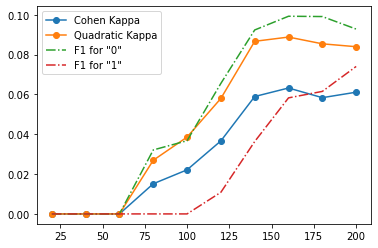

In [23]:
plt.plot(np.arange(1,11) * 20, scores[:,3], '-o', label = "Cohen Kappa")
plt.plot(np.arange(1,11) * 20, scores[:,4], '-o', label = "Quadratic Kappa")
plt.plot(np.arange(1,11) * 20, scores[:,0], '-.', label = 'F1 for "0"')
plt.plot(np.arange(1,11) * 20, scores[:,1], '-.', label = 'F1 for "1"')
plt.legend()
plt.savefig("scores_vs_steps.png")

In [25]:
scores[:,1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01086957, 0.03636364, 0.0582878 , 0.06153846, 0.07407407])